In [ ]:
#import termios
from ctypes import *
import msvcrt
import os
import subprocess
import sys
from google.colab import drive
drive.mount('/00')

# Hand Gesture Recognition

Why this task:<br>
* Different interesting applications.
* Open data.
* Easy to solve by CNN architecture.

# Data 

The Hand Gesture Recognition Database is a collection of near-infra-red images of ten distinct hand gestures. <br>
https://www.kaggle.com/gti-upm/leapgestrecog<br>
T. Mantecón, C.R. del Blanco, F. Jaureguizar, N. García, “Hand Gesture Recognition using Infrared Imagery Provided by Leap Motion Controller”, Int. Conf. on Advanced Concepts for Intelligent Vision Systems, ACIVS 2016, Lecce, Italy, pp. 47-57, 24-27 Oct. 2016. (doi: 10.1007/978-3-319-48680-2_5)

In [1]:
import numpy as np 
import os
from PIL import Image 
import matplotlib.pyplot as plt
from matplotlib import image
import matplotlib.image as mpimg 
import numpy as np
import cv2

We have one 00 folder with images from a given subject. There are subfolders for each gesture. We'll build a dictionary lookup storing the names of the gestures we need to identify, and giving each gesture a numerical identifier. We'll also build a dictionary reverselookup that tells us what gesture is associated to a given identifier.

In [2]:
lookup = dict()
reverselookup = dict()
count = 0
#for j in os.listdir('/00/My Drive/00/'):
for j in os.listdir('00/00'):
    if not j.startswith('.'):  
                              
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'01_palm': 0,
 '02_l': 1,
 '03_fist': 2,
 '04_fist_moved': 3,
 '05_thumb': 4,
 '06_index': 5,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 8,
 '10_down': 9}

Next we read in the images, storing them in x_data. We store the number of classes for each image in y_data. We can convert images to greyscale and resizing to speed up the computations.

In [3]:
x_data = []
y_data = []
datacount = 0 
datadir = 'C:/Users/camil/Desktop/my own study/study of ml/ML1-2-3/ml3/Lab_10/00/00'
folders =['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']
#for i in range(0, 10): # Loop over the ten top-level folders
for j in folders:
    if not j.startswith('.'): 
        count = 0 
        path = os.path.join(datadir, j)
        for k in os.listdir(path):
            img = Image.open(path + '/' + k).convert('L')
            img = img.resize((320, 120))
            arr = np.array(img)
            x_data.append(arr) 
            count = count + 1
        y_values = np.full((count, 1), lookup[j]) 
        y_data.append(y_values)
        datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

Show one image for each subfolder or each gesture.

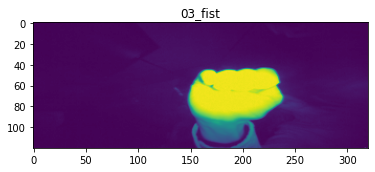

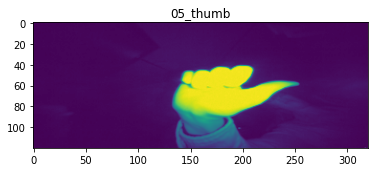

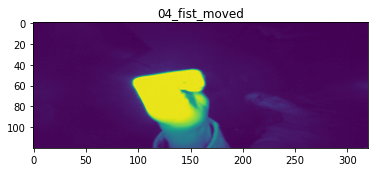

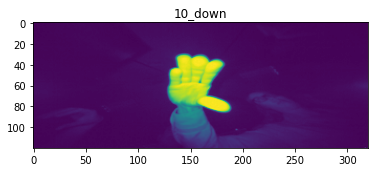

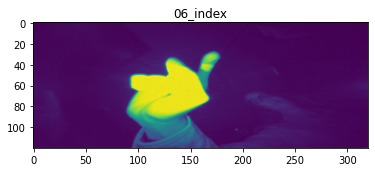

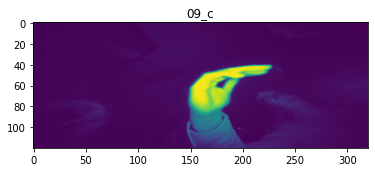

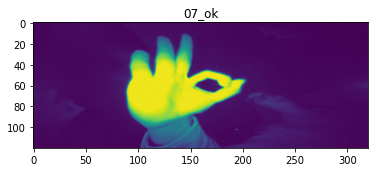

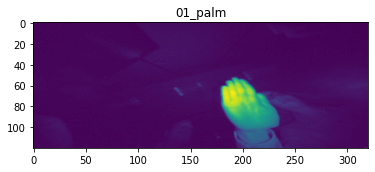

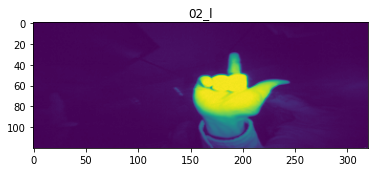

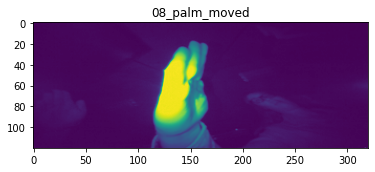

In [5]:
for i in range(0, 10):
    plt.imshow(x_data[i*200 , :, :])
    plt.title(reverselookup[y_data[i*200 ,0]])
    plt.show()

This task can be solve by CV algorithm for example an edge detection.
Our y_data contains has shape (datacount, 1), we convert it to one-hot format by the keras function to_categorical.

In [6]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [7]:
import keras
from keras.utils import to_categorical
y_data = to_categorical(y_data)

In [8]:
x_data = x_data.reshape((datacount, 120, 320, 1))
x_data /= 255

In order to get an 80-10-10 split, we call train_test_split twice, first to split 80-20, then to split the smaller chunk 50-50. 

In [9]:
from sklearn.model_selection import train_test_split
x_train,x_further,y_train,y_further = train_test_split(x_data,y_data,test_size = 0.2)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5)

In [10]:
print(x_train.shape, x_validate.shape, x_test.shape)

(1600, 120, 320, 1) (200, 120, 320, 1) (200, 120, 320, 1)


Compare previous result with ResNet50.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50

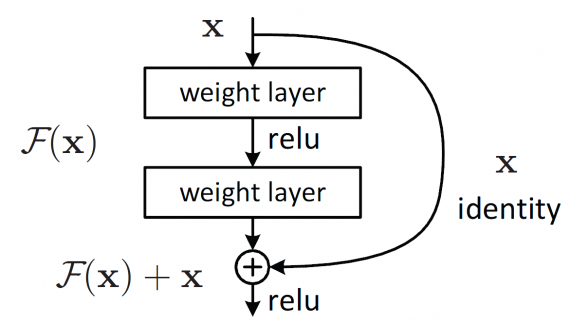

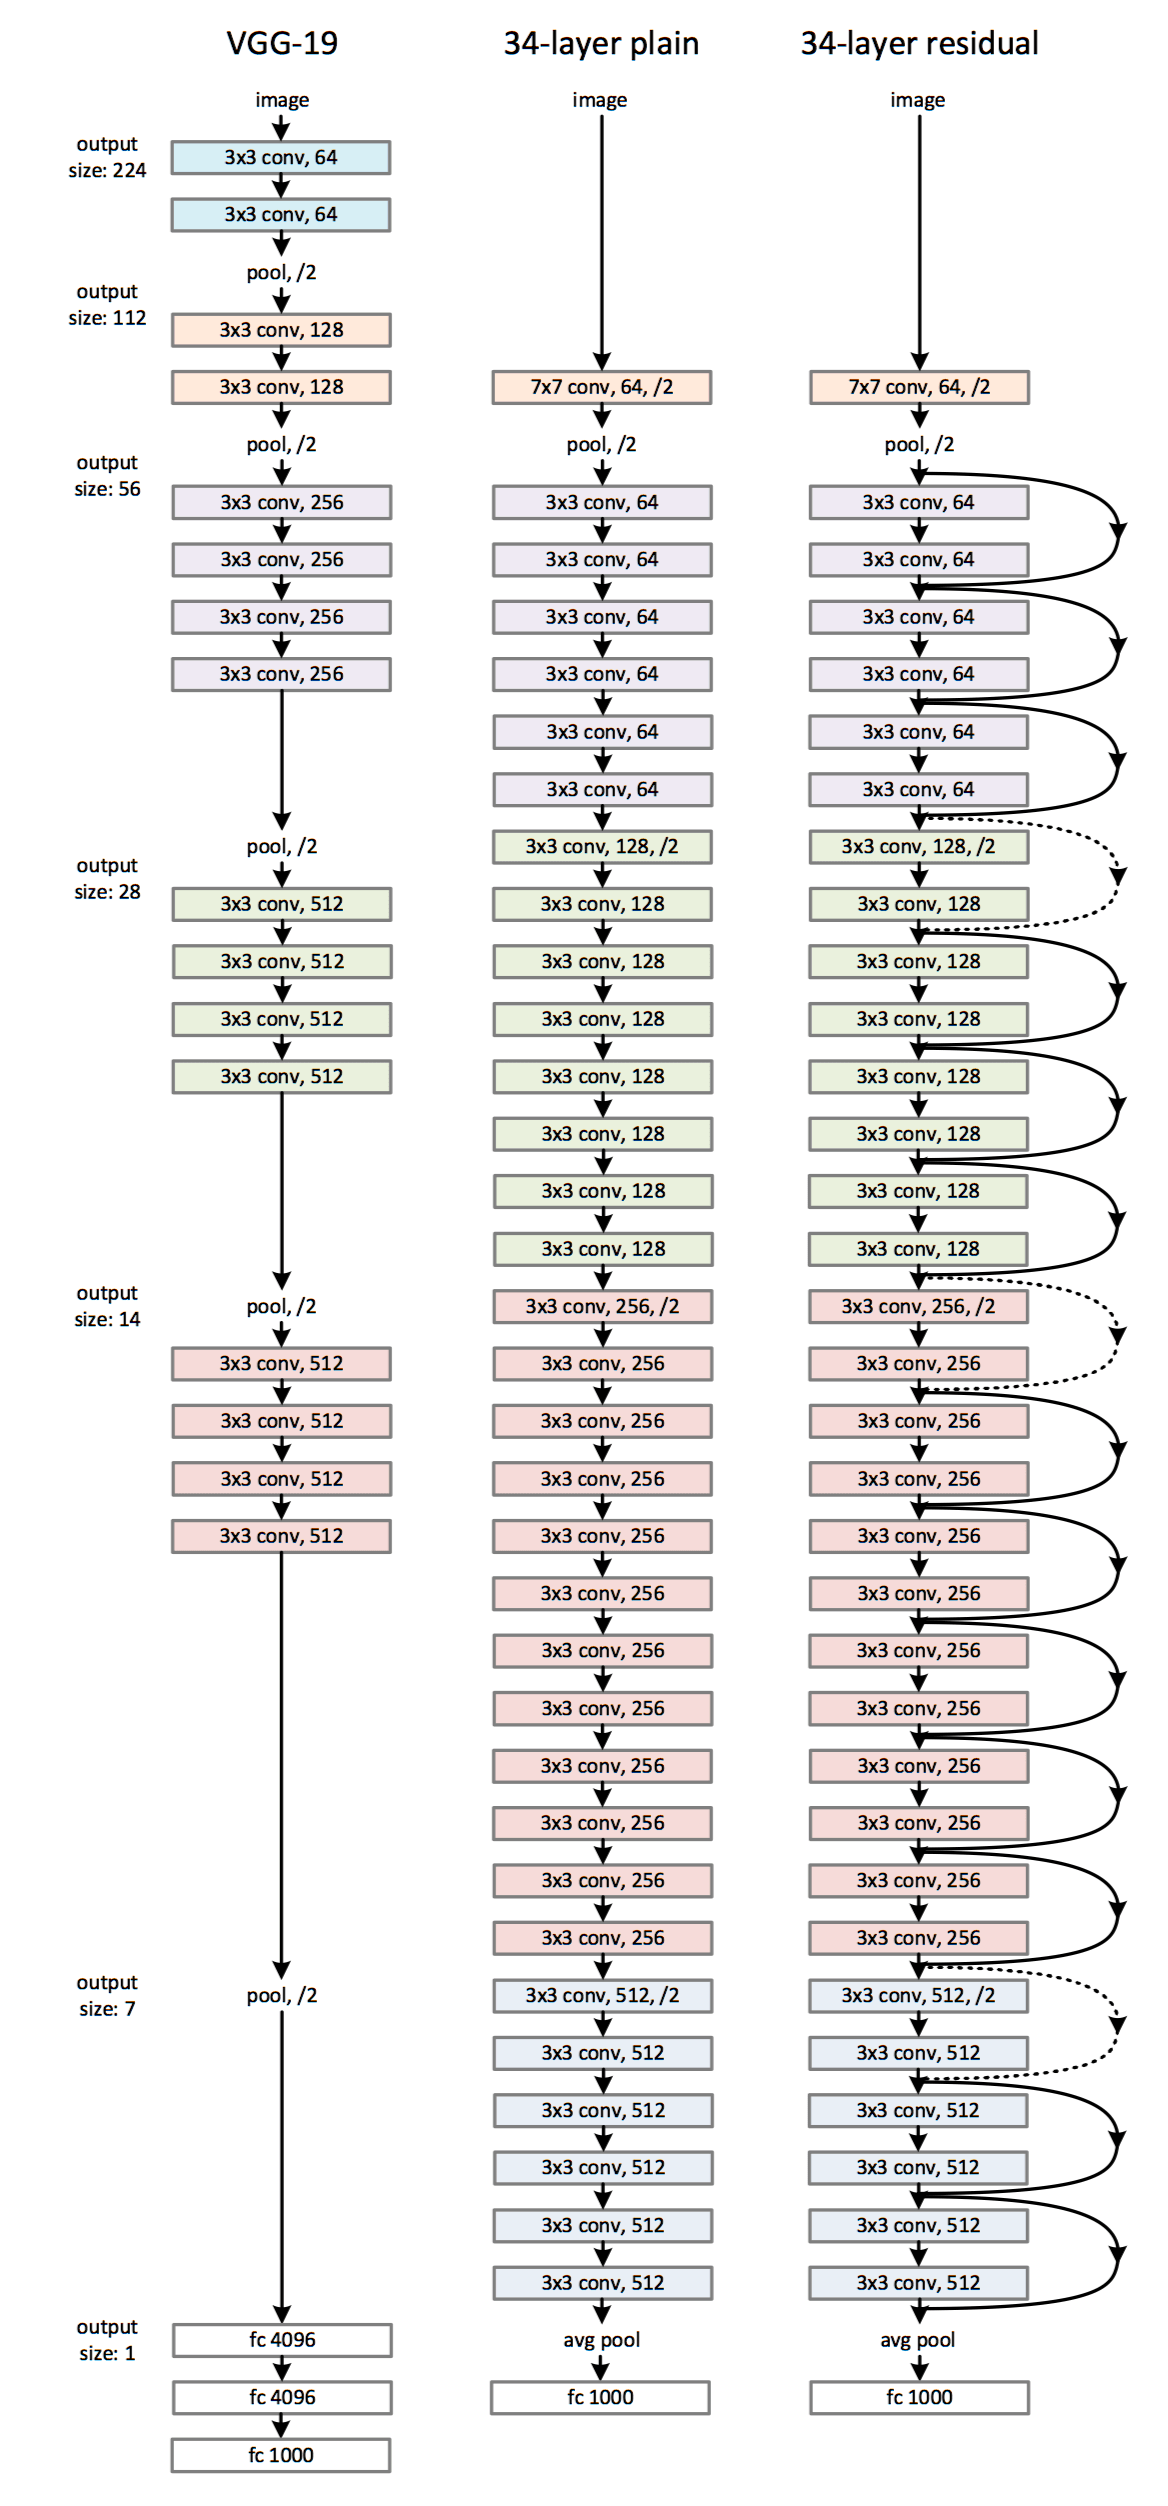

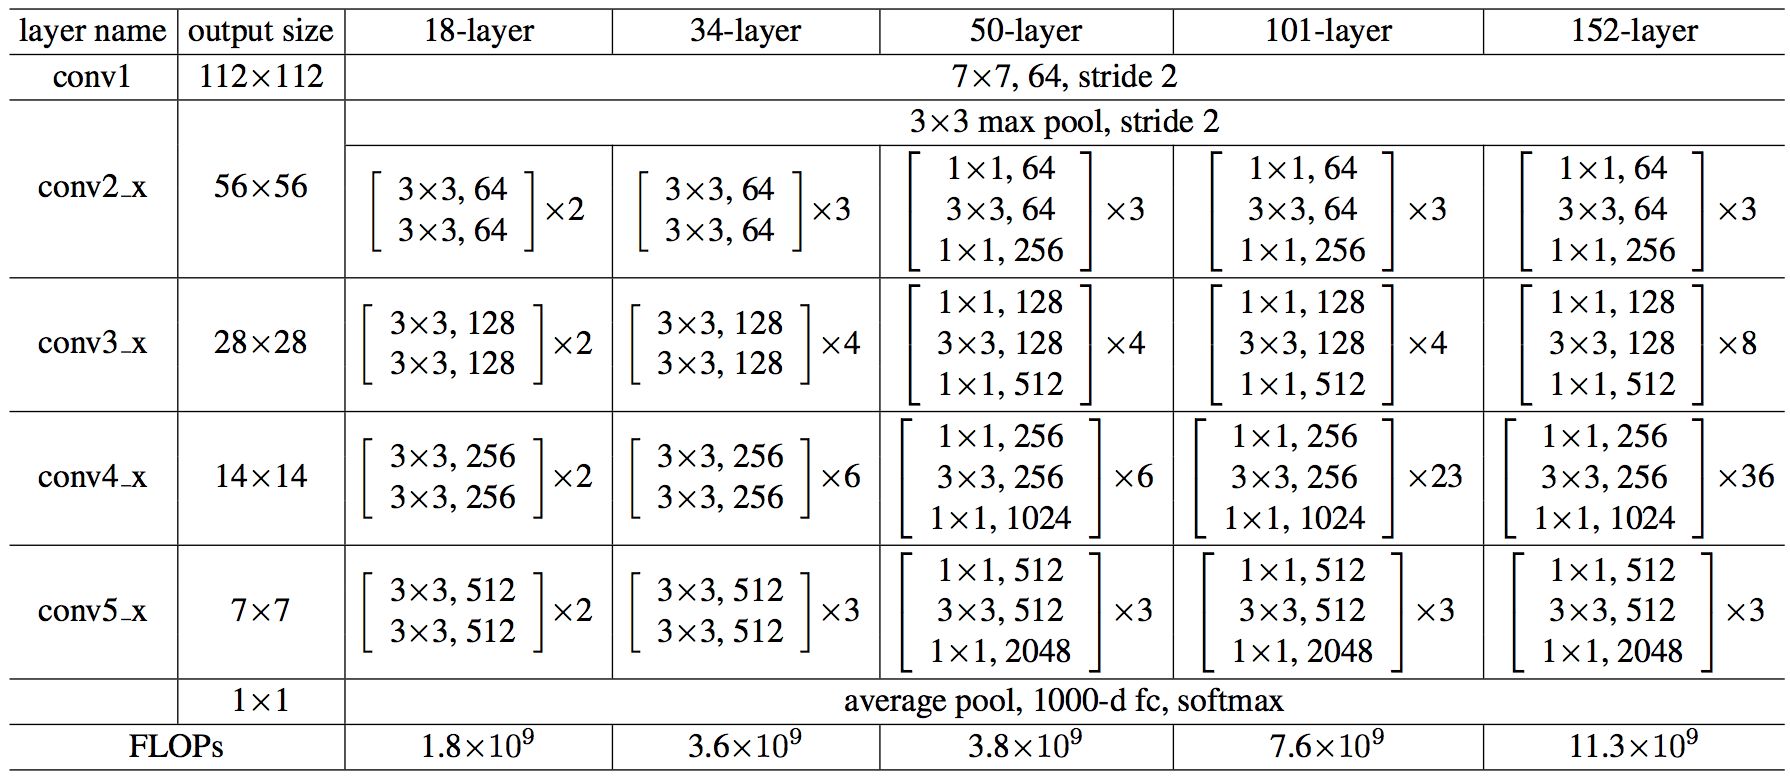

In [11]:
from tensorflow.keras.applications import ResNet50

In [12]:
resnet = tf.keras.applications.ResNet50(
weights=None, input_tensor=None, input_shape=(120,320,1),
pooling=None, classes=10
)
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 320, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 126, 326, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 60, 160, 64)  3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 60, 160, 64)  256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [13]:
resnet.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model = resnet.fit(x_train, y_train, batch_size=64,
                        epochs=5,
                        validation_data=(x_validate, y_validate))

Epoch 1/5
25/25 [==============================] - 58s 696ms/step - loss: 3.9522 - accuracy: 0.2790 - val_loss: 1430.6147 - val_accuracy: 0.0850
Epoch 2/5
25/25 [==============================] - 16s 640ms/step - loss: 0.6177 - accuracy: 0.8200 - val_loss: 2.8206 - val_accuracy: 0.1600
Epoch 3/5
25/25 [==============================] - 16s 639ms/step - loss: 0.5083 - accuracy: 0.8428 - val_loss: 101.6747 - val_accuracy: 0.0850
Epoch 4/5
25/25 [==============================] - 16s 640ms/step - loss: 0.0666 - accuracy: 0.9842 - val_loss: 438.3082 - val_accuracy: 0.0850
Epoch 5/5
25/25 [==============================] - 16s 640ms/step - loss: 0.1291 - accuracy: 0.9634 - val_loss: 6.8532 - val_accuracy: 0.1150


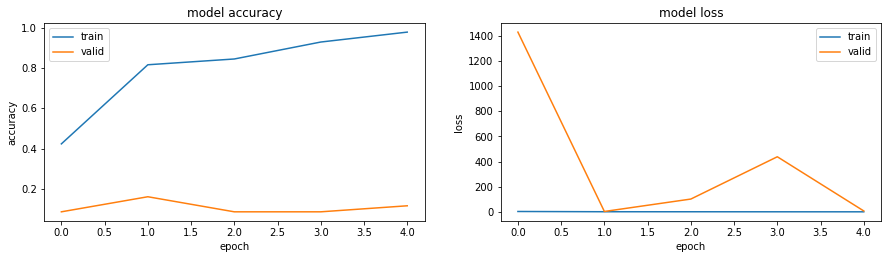

In [14]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(model.history['accuracy'])  
plt.plot(model.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(model.history['loss'])  
plt.plot(model.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

# Task
You schould read images from folders, labels stored in name of folders:
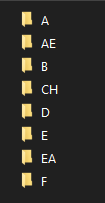

After you should split it to train, validation and test dataset, next step is to train ResNet50 on your data.

In [2]:
#NOTE: i updated kernel and jupyter notebook and run at the same time this notebook - it is actually taking a lot of time, 
#so i decided to upload this one for a moment 
#import all libs i needed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import keras
import os
from PIL import Image 
import matplotlib.pyplot as plt
from matplotlib import image
import matplotlib.image as mpimg 
import numpy as np
import cv2
from keras.utils import to_categorical
import time
from sklearn.metrics import confusion_matrix
import seaborn as sn
import random
from sklearn.model_selection import train_test_split

In [3]:
#define my values before working with it
x_data = []
y_data = []
datacount = 0 
lookup = dict()
reverselookup = dict()
count = 0
datadir = "C:\\Users\\camil\\Desktop\\my own study\\study of ml\\ML1-2-3\\ml3\\Lab_12\\Lab_12_1\\Lab_12\\Small_dataset"
categories = ["A", "AE", "B", "CH", "D", "E", "EA", "F"]

In [4]:
#i got code from above to use
datacount = 0 
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir(datadir):
    if not j.startswith('.'):  
                              
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'A': 0, 'AE': 1, 'B': 2, 'CH': 3, 'D': 4, 'E': 5, 'EA': 6, 'F': 7}

In [5]:
#read folders images in categories
for category in categories:
    if not category.startswith('.'): 
        count = 0
        path = os.path.join(datadir, category)
        for k in os.listdir(path):
            #if we dont have such file i simnply skip in folder and go on
            #until i find it somewhere
            isExist =os.path.exists(path+"\\"+k)#10,12 
            if isExist==False:
                continue
            #and here i get all my images
            else:
                img = Image.open(path+"\\"+k).convert('L')
                img = img.resize((120, 320))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
        y_values = np.full((count, 1), lookup[j]) 
        y_data.append(y_values)
        datacount = datacount + count
#get my data corrected
x_data = np.array(x_data, dtype = 'float32')
print(len(y_data))
y_data = np.array(y_data)
y_data = y_data.reshape(8, 1) # Reshape to be the correct size

8


<ipython-input-5-dbcc105bfbe2>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_data = np.array(y_data)


In [6]:
#convert our data
y_data = to_categorical(y_data.shape)
#reshape our data
x_data = x_data.reshape((2, 1600, 952, 3))
x_data = x_data / 255.0

In [7]:
#i keep this code here in order to free up cache if i fill it too much
#del xx_test
import gc
gc.collect()
#this code here is just to check if my data is correct - this is my draft copy
#yy_data = y_data
#y=yy_data.reshape((yy_data.shape[:1]))
y_data.shape
#datacount
#type(y_data)

(2, 9)

In [8]:
#split to train and test dataset
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,train_size=0.7, test_size=0.3)

In [9]:
#it says that my daat will be empty and i dont know what to do in order to fix it
#i chekced my path - it is correct
#i changed train/test sizes - yet it did not work, so i just chekc them out
#x_val,X_test,y_val,Y_test = train_test_split(x_test, y_test, test_size=0.2)
#so i decided to do something else

In [10]:
#prepare out data
#reshape into images so i can work with it
img_rows, img_cols , channels= 1600, 952, 3
xx_train = x_train.reshape(y_train.shape[0], img_rows, img_cols, channels)
xx_test = x_test.reshape(y_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', xx_train.shape)
print(xx_train.shape[0], 'train samples')
print(xx_test.shape[0], 'test samples')
#convert integers to float; normalise and center the mean 
x_test=xx_test.astype("float32")
mean=np.mean(xx_train)
std=np.std(xx_train)
x_test=(xx_test-mean)/std
#x_test = x_test/255.0
#y_test =  to_categorical(y_test.shape)

x_train shape: (1, 1600, 952, 3)
1 train samples
1 test samples


In [11]:
#create location of my log
root_logdir = os.path.join(os.curdir, "logs\\fit\\")

#fuction to get it
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
#after it, i run the function to get my  log
run_logdir = get_run_logdir()
#where i call it and save as callback for later use
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [12]:
#call resnet50 model
res_net = tf.keras.applications.ResNet50(weights=None, input_tensor=None, input_shape=(1600, 952, 3),
                                         pooling=None, classes=9)
res_net.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1600, 952, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 1606, 958, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 800, 476, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 800, 476, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [13]:
#use imagedatagenerator - augmentate our data and save as one train/test data
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=x_train, y=y_train)

In [14]:
#compile our model - binary acc since my data acc
res_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
#fit our model to new data
model2 = res_net.fit(traindata, batch_size=32, epochs=5, validation_data=(x_test, y_test),
                     verbose = 1, callbacks=[tensorboard_cb]) 

Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.4581 - binary_accuracy: 0.8889 - val_loss: 0.4067 - val_binary_accuracy: 0.8889
Epoch 2/5
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 2s 2s/step - loss: 0.0020 - binary_accuracy: 1.0000 - val_loss: 0.6555 - val_binary_accuracy: 0.8889
Epoch 3/5
1/1 [==============================] - 2s 2s/step - loss: 4.4348e-05 - binary_accuracy: 1.0000 - val_loss: 1.2125 - val_binary_accuracy: 0.8889
Epoch 4/5
1/1 [==============================] - 2s 2s/step - loss: 2.5100e-06 - binary_accuracy: 1.0000 - val_loss: 1.8876 - val_binary_accuracy: 0.7778
Epoch 5/5
1/1 [==============================] - 2s 2s/step - loss: 4.3512e-06 - binary_accuracy: 1.0000 - val_loss: 1.9448 - val_binary_accuracy: 0.7778


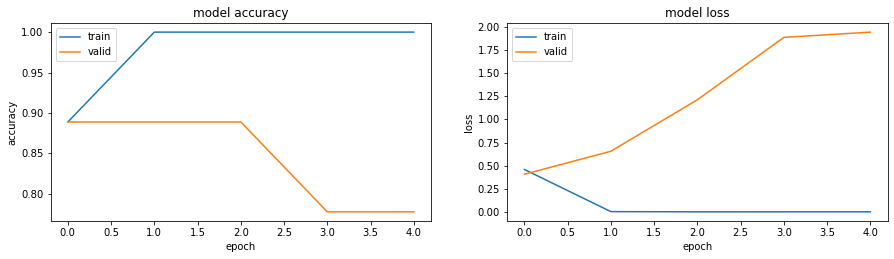

In [15]:
#plot history of new model on new data
plt.figure(1, figsize = (15,8)) 
#loss plot    
plt.subplot(221)  
plt.plot(model2.history['binary_accuracy'])  
plt.plot(model2.history['val_binary_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
#plot accuracy   
plt.subplot(222)  
plt.plot(model2.history['loss'])  
plt.plot(model2.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [8]:
#here i call for tenserboard with magic fucntion and load my data (i have newwer version of TF)
%load_ext tensorboard
%tensorboard --logdir logs/fit
#feel free to see and use tenserboard below as you desire - free pids
#del /q %TMP%\.tensorboard-info\* - free pids

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 12044), started 0:03:11 ago. (Use '!kill 12044' to kill it.)

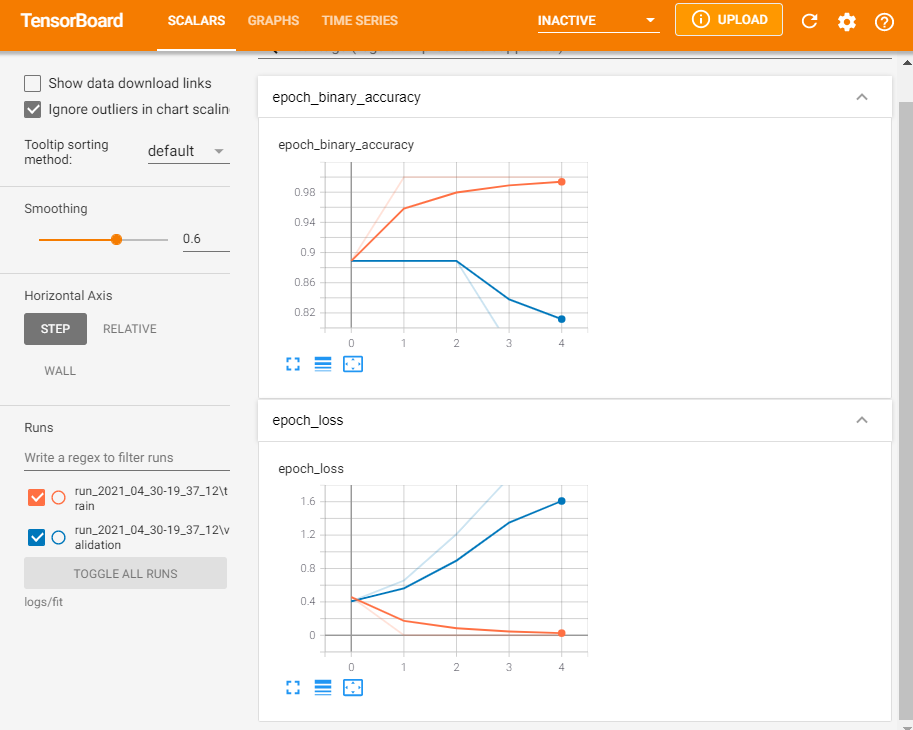

In [9]:
#also i added screenshot of how it looks in my notebook, so just in case if doesnot open/support in/on your computer 
from PIL import Image
#used pillow to open screenshot
im = Image.open("resnet50.png")
im

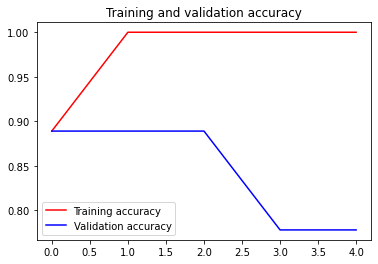

<Figure size 432x288 with 0 Axes>

In [27]:
#but if you dont have tensorboard here is the plot of graphs with same code as above
acc = model2.history['binary_accuracy']
val_acc = model2.history['val_binary_accuracy']
loss = model2.history['loss']
val_loss = model2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [31]:
#calculate loss and accuracy on test data
test_loss, test_accuracy = res_net.evaluate(x_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))

1/1 [==============================] - 0s 2ms/step - loss: 1.9448 - binary_accuracy: 0.7778
Test accuracy: 77.78%


## Summary

ResNet50 with augmented data and new data of hand gestures - a bit weird interaction. I had wierd graph in lab 10 and also above before task. Yet. here is my outcomes:<br>
- When deeper networks starts converging, a degradation problem has been exposed: with the network depth increasing, accuracy gets saturated and then degrades rapidly<br>
- In the deeper network the additional layers better approximates the mapping than it’s shallower counter part and reduces the error by a significant margin<br>
- 3x3 filters mostly, 2 stride, 1000way layers fully connected with Softmax at the end<br>
- pytorch can be used to implement resnet50<br>
- Residual Networks is a classic neural network used as a backbone for many computer vision tasks<br>